# Flax and NumPyro Toy Example

In this notebook I want to experiment with the [`numpyro/contrib/module.py`](https://github.com/pyro-ppl/numpyro/blob/master/numpyro/contrib/module.py) module which allow us to integrate [`Flax`](https://github.com/google/flax) models with [`NumPyro`](https://github.com/pyro-ppl/numpyro) models. I am interested in this because I want to experiment with complex bayesian models with larger datasets.

Most of the main components can be found in the great blog post [Bayesian Neural Networks with Flax and Numpyro](https://omarfsosa.github.io/bayesian_nn). The author takes a different path working directly with potentials, but he also points out the recent addition of the `numpyro/contrib/module.py` module. The main difference with the model presented here is that I am using two components in the model (to model the mean and standard deviation of the data), I use *stochastic variational inference*  instead of *MCMC* and I work with scaling transformations.

Another great source to learn about this model and expected behaviour are the unit tests of the [`numpyro/contrib/module.py`] module 😄. 

**Remark:** Note that there is a way of adding [`Flax`](https://github.com/google/flax) models into [PyMC](https://github.com/pymc-devs/pymc), see [How to use JAX ODEs and Neural Networks in PyMC](https://www.pymc-labs.com/blog-posts/jax-functions-in-pymc-3-quick-examples/).

## Prepare Notebook

In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import seaborn as sns
import xarray as xr
from flax import linen as nn
from jax import random
from numpyro.contrib.module import flax_module
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from numpyro.infer.util import Predictive
from sklearn.preprocessing import StandardScaler

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Generate Synthetic Data

We generate a simple one-dimensional dataset with a non-linear relationship between the input and output.

In [2]:
n = 32 * 10
rng_key, rng_subkey = random.split(rng_key)
x = random.uniform(rng_key, shape=(n,), minval=1, maxval=jnp.pi)
mu_true = jnp.sqrt(x + 0.5) * jnp.sin(9 * x)
sigma_true = 0.15 * x**2
rng_key, rng_subkey = random.split(rng_key)
y = mu_true + sigma_true * random.normal(rng_key, shape=(n,))

Note that we are actually adding non-linearities to the mean and standard deviation of the data.

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

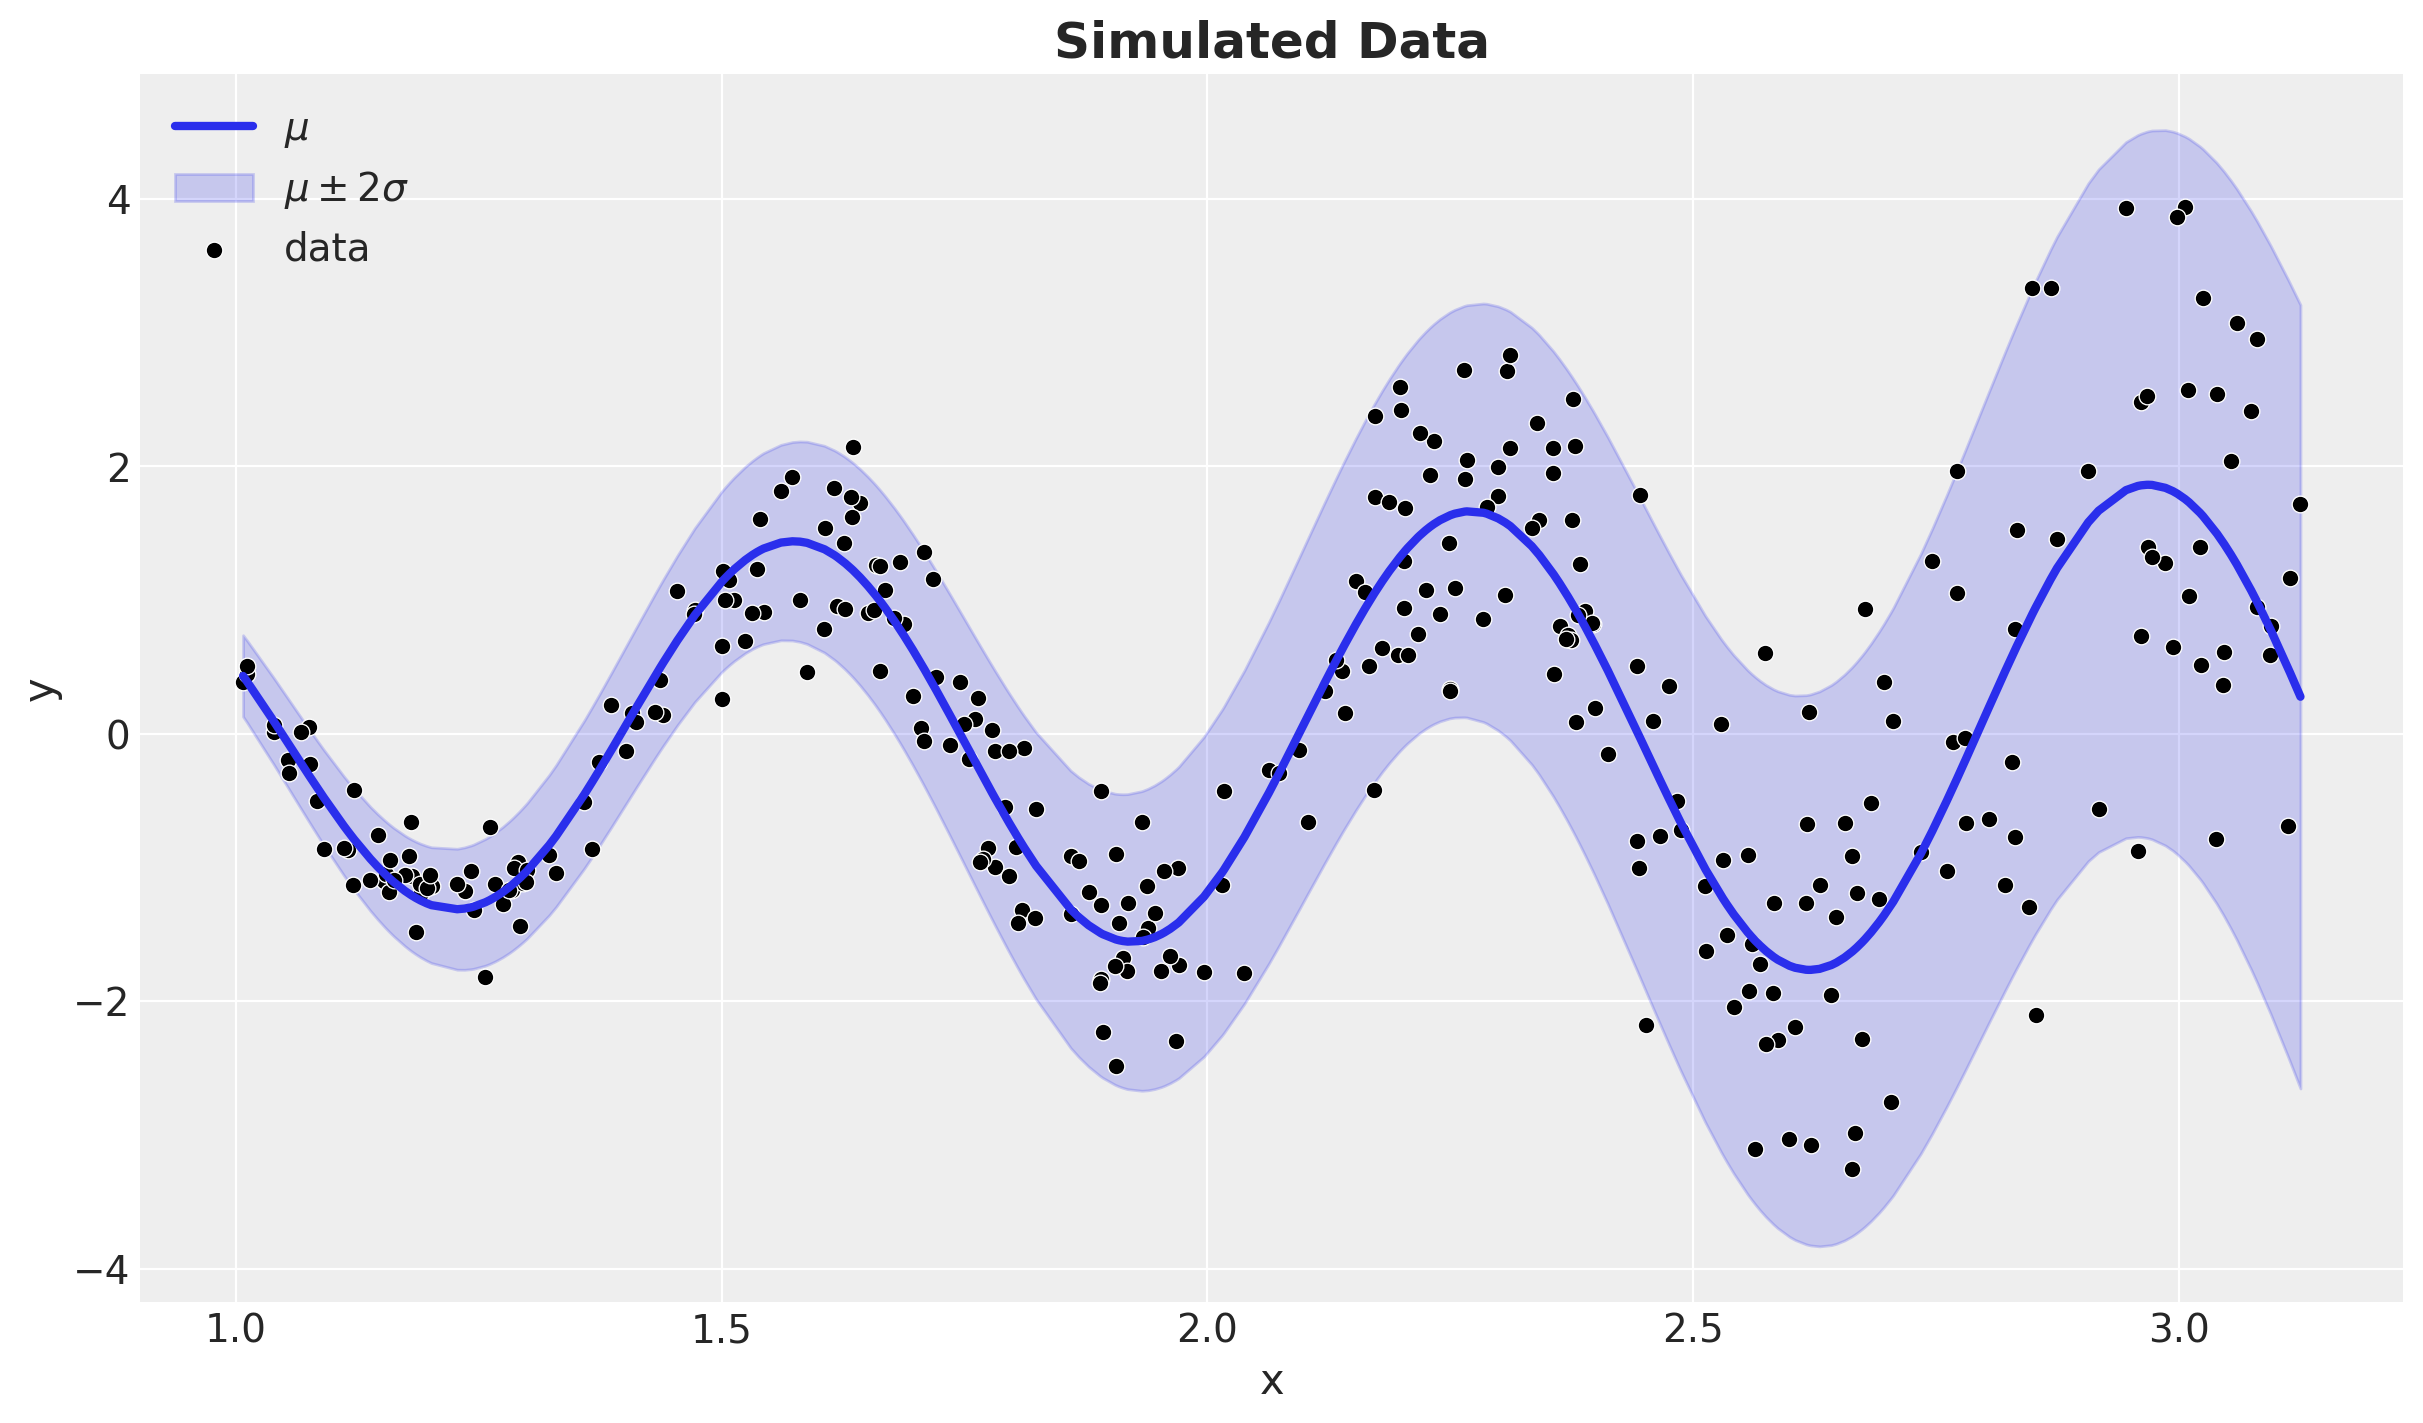

In [3]:
x_idx = jnp.argsort(x)

fig, ax = plt.subplots()
sns.lineplot(x=x, y=mu_true, color="C0", label=r"$\mu$", linewidth=3, ax=ax)
ax.fill_between(
    x[x_idx],
    (mu_true - 2 * sigma_true)[x_idx],
    (mu_true + 2 * sigma_true)[x_idx],
    color="C0",
    alpha=0.2,
    label=r"$\mu \pm 2 \sigma$",
)
sns.scatterplot(x=x, y=y, color="black", label="data", ax=ax)
ax.legend(loc="upper left")
ax.set_title(label="Simulated Data", fontsize=18, fontweight="bold")
ax.set(xlabel="x", ylabel="y")

## Train-Test Split

We now do a simple train-test split of the data.

In [4]:
train_test_split = 0.7
train_idx = int(n * train_test_split)
x_train, y_train = x[:train_idx], y[:train_idx]
x_test, y_test = x[train_idx:], y[train_idx:]

In [5]:
# useful variables for indexing
obs_train = jnp.arange(x_train.size)
obs_test = jnp.arange(x_test.size) + x_train.size

Let's see both datasets:

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

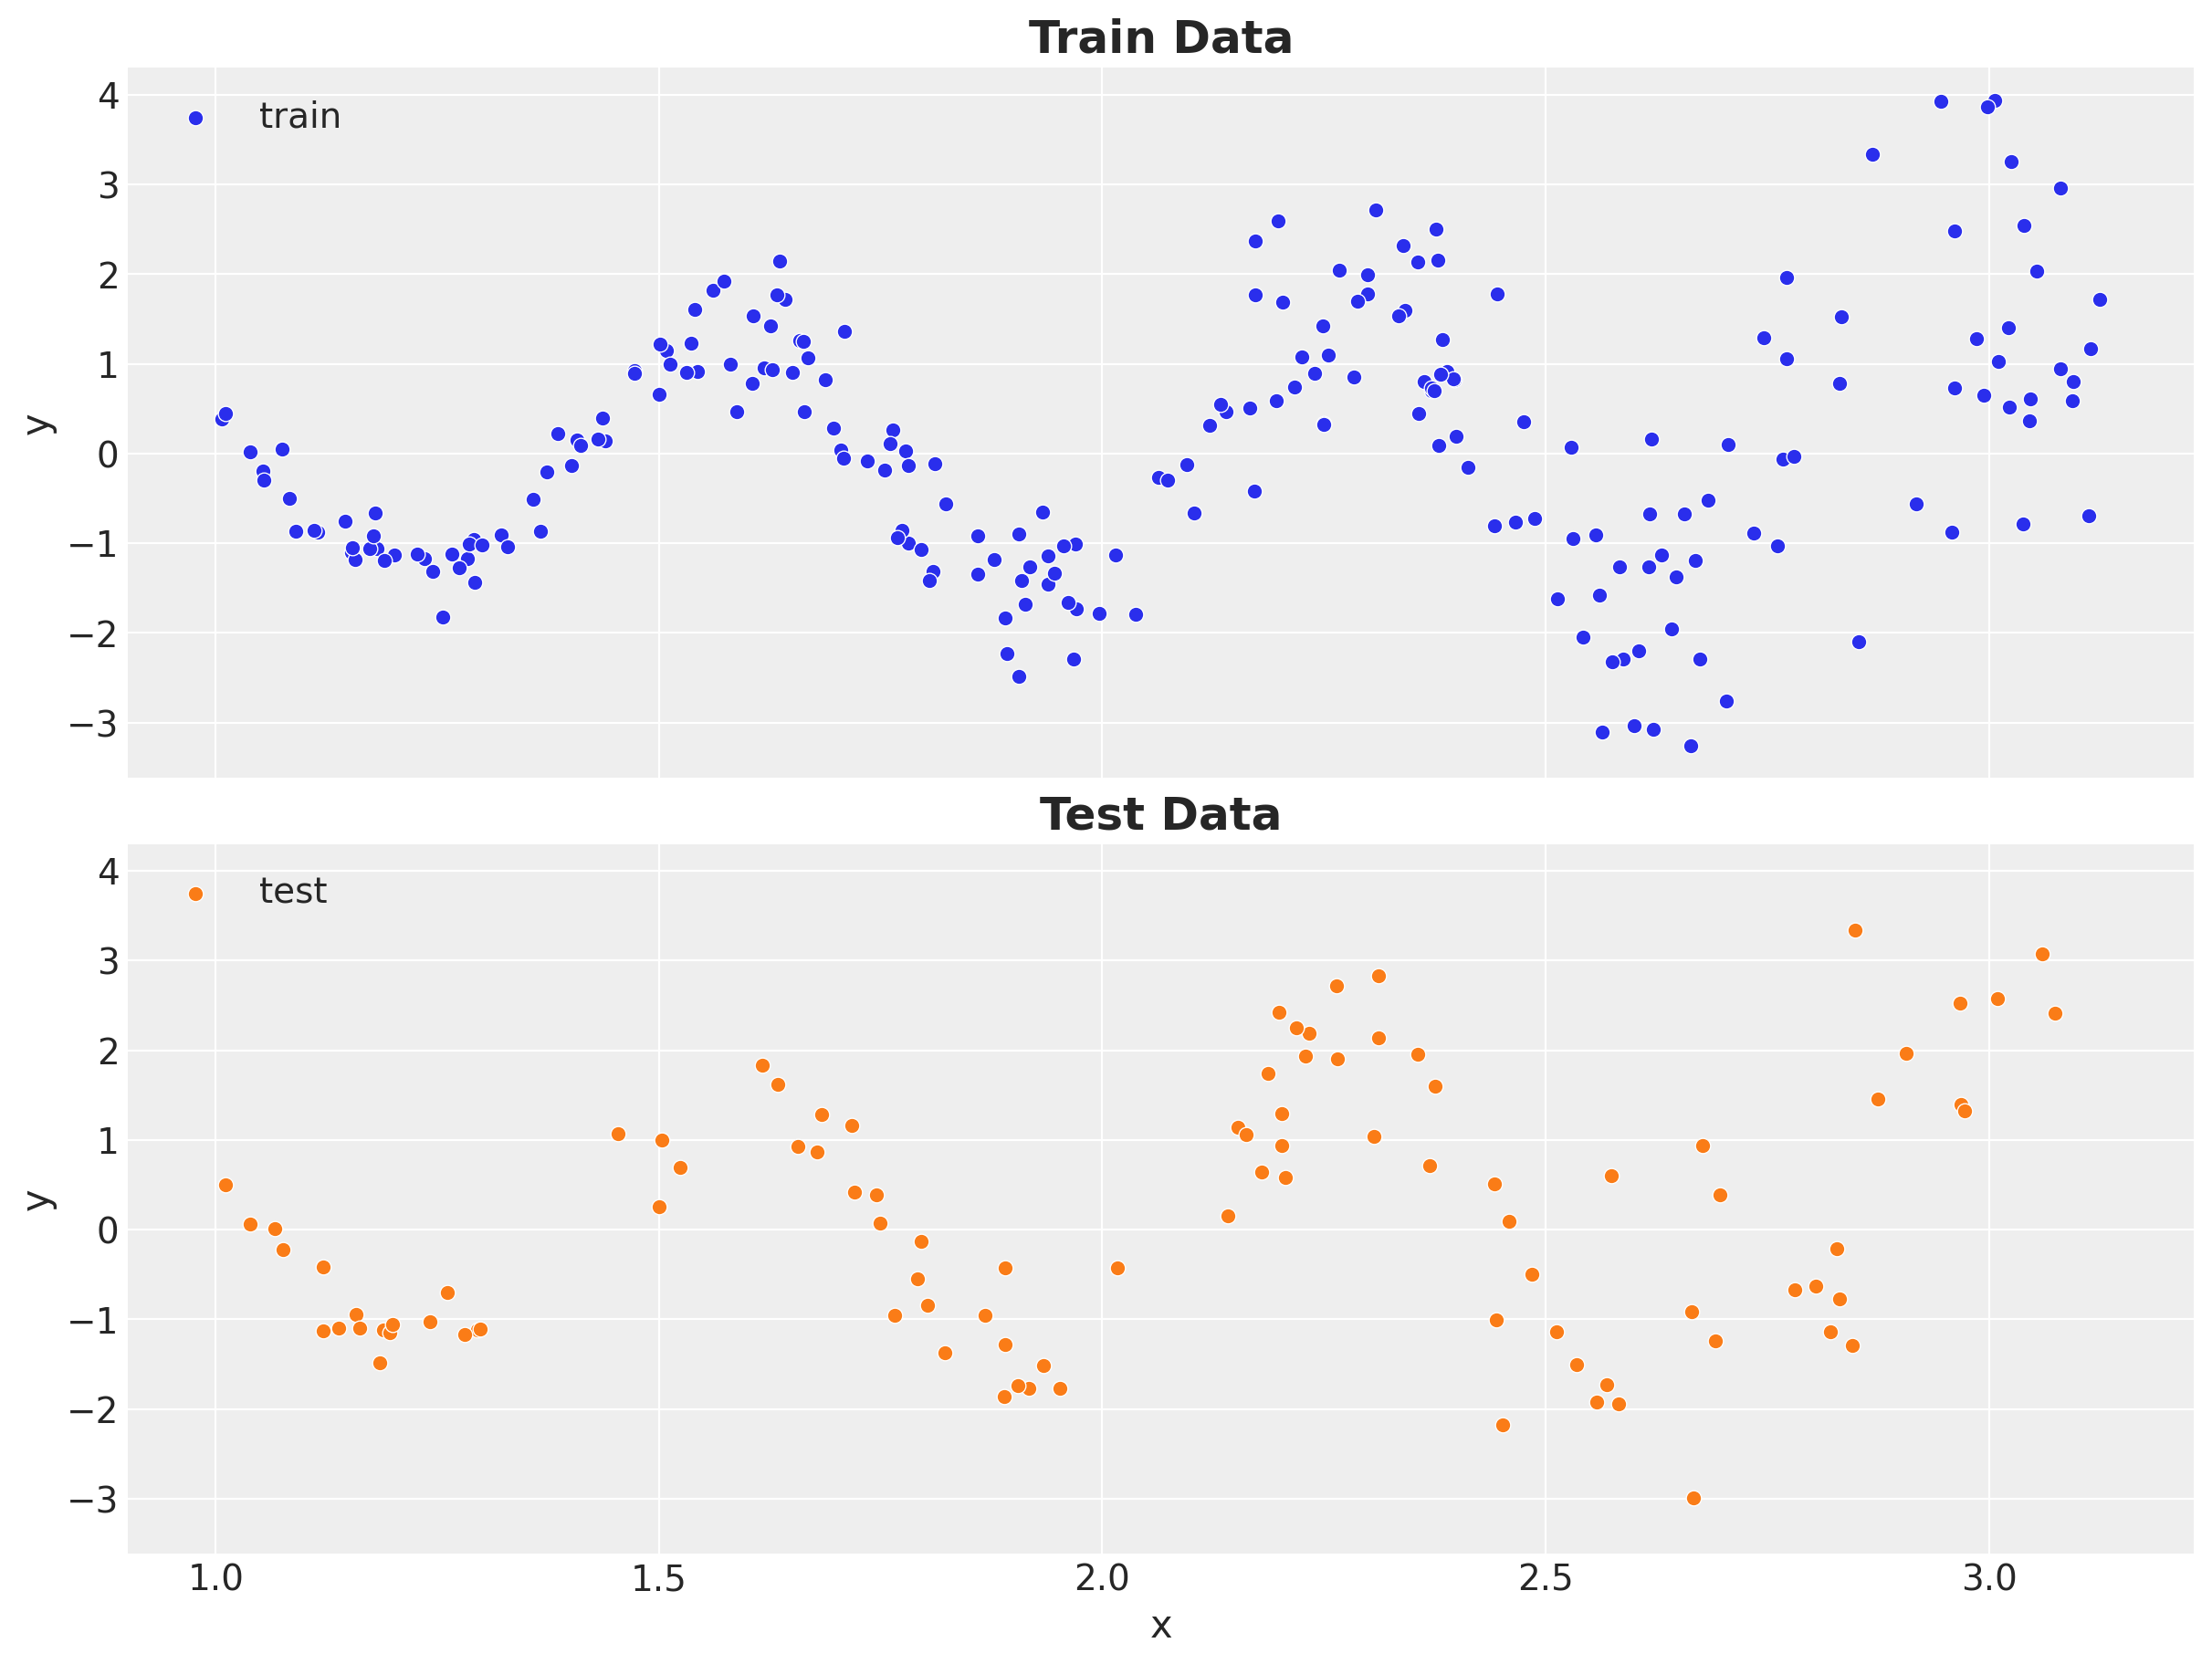

In [6]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, sharex=True, sharey=True, figsize=(12, 9), layout="constrained"
)
sns.scatterplot(x=x_train, y=y_train, color="C0", label="train", ax=ax[0])
ax[0].legend(loc="upper left")
ax[0].set_title(label="Train Data", fontsize=18, fontweight="bold")
ax[0].set(xlabel="x", ylabel="y")
sns.scatterplot(x=x_test, y=y_test, color="C1", label="test", ax=ax[1])
ax[1].legend(loc="upper left")
ax[1].set_title(label="Test Data", fontsize=18, fontweight="bold")
ax[1].set(xlabel="x", ylabel="y")

## Data Preprocessing

As we want to use a neural network to model the mean and standard deviation of the data, we need to scale the data. We use a [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) from [`sklearn`](https://scikit-learn.org/stable/) to do this.

In [7]:
x_scaler = StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train[:, None])
x_train_scaled = jnp.array(x_train_scaled)
x_test_scaled = x_scaler.transform(x_test[:, None])
x_test_scaled = jnp.array(x_test_scaled)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train[:, None])
y_train_scaled = y_train_scaled.squeeze()
y_train_scaled = jnp.array(y_train_scaled)
y_test_scaled = y_scaler.transform(y_test[:, None])
y_test_scaled = y_test_scaled.squeeze()
y_test_scaled = jnp.array(y_test_scaled)

**Remark:** Note that the feature matrices `x_train` and `x_test` have dimension $2$ as the first dimension represent the `batch` component! For the target variables we simply have a vector.

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

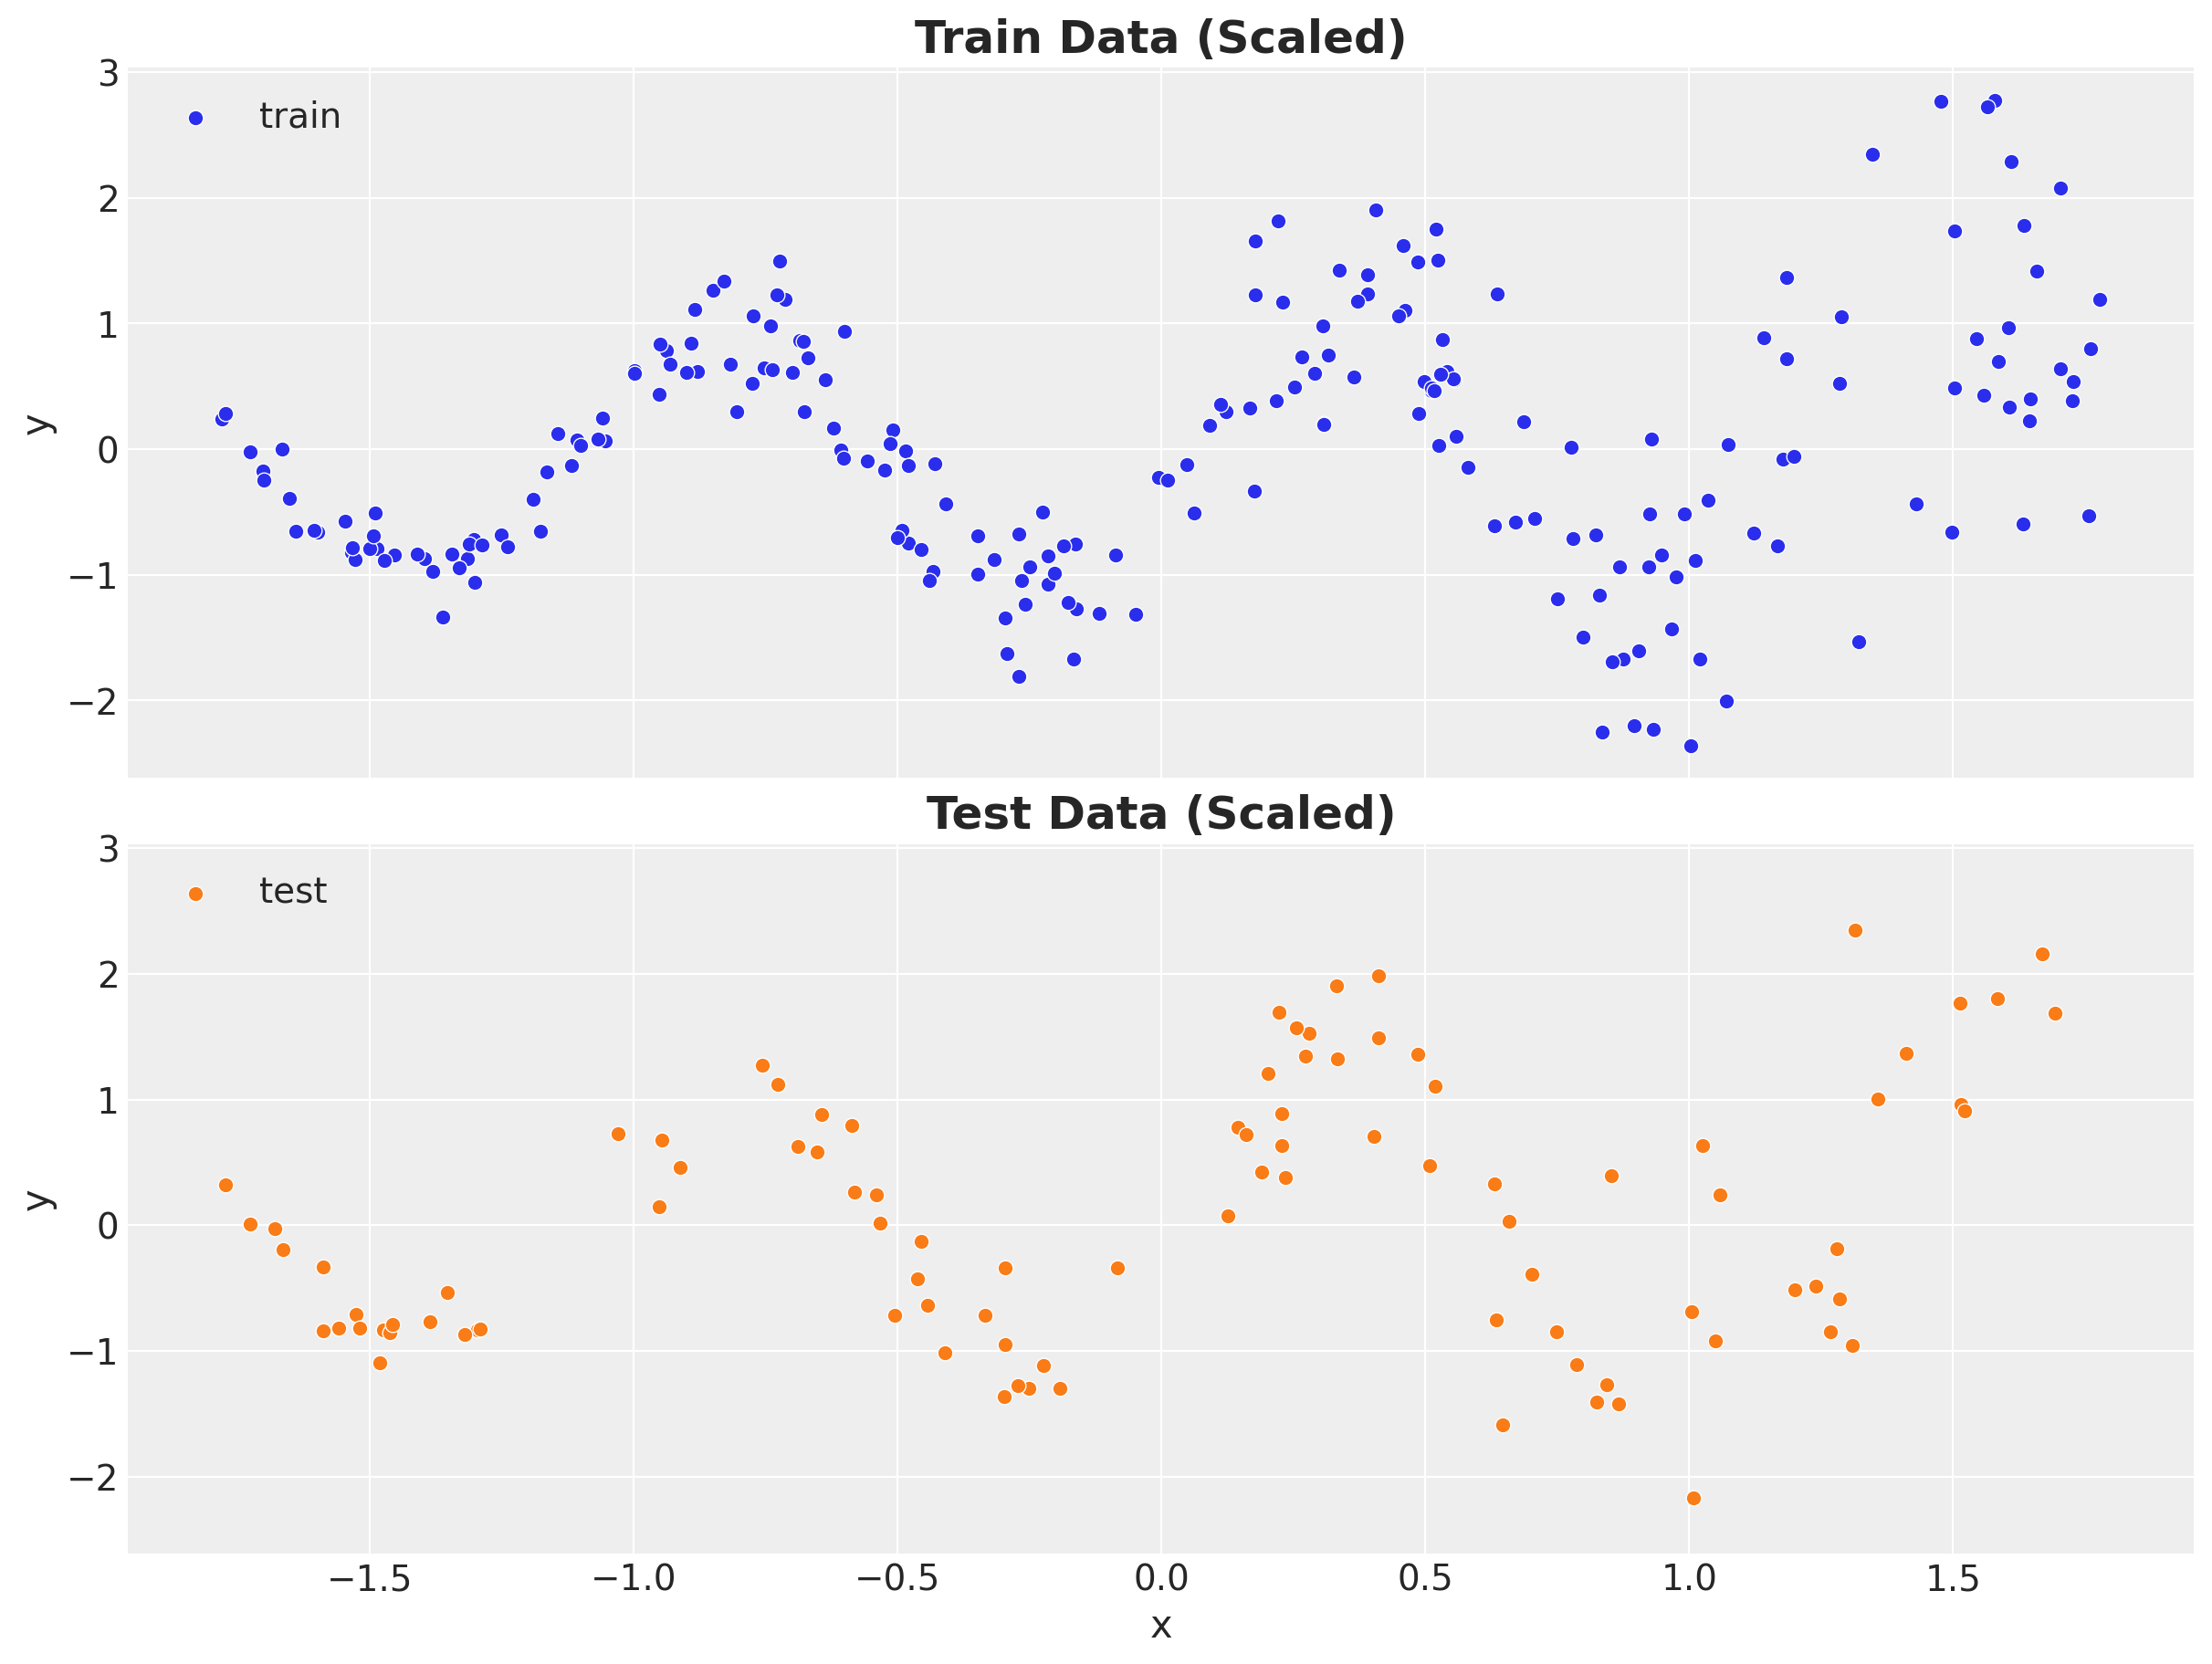

In [8]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, sharex=True, sharey=True, figsize=(12, 9), layout="constrained"
)
sns.scatterplot(
    x=x_train_scaled.squeeze(),
    y=y_train_scaled,
    color="C0",
    label="train",
    ax=ax[0],
)
ax[0].legend(loc="upper left")
ax[0].set_title(label="Train Data (Scaled)", fontsize=18, fontweight="bold")
ax[0].set(xlabel="x", ylabel="y")
sns.scatterplot(
    x=x_test_scaled.squeeze(),
    y=y_test_scaled,
    color="C1",
    label="test",
    ax=ax[1],
)
ax[1].legend(loc="upper left")
ax[1].set_title(label="Test Data (Scaled)", fontsize=18, fontweight="bold")
ax[1].set(xlabel="x", ylabel="y")

## Model Specification

We now specify the model. We use a simple feed-forward neural network or multilayer perceptron (MLP) to model both the mean and standard deviation of the data. We then pass it through Normal likelihoods distribution in a `NumPyro` model.

First, we define the MLP with `Flax`:

In [9]:
class MLP(nn.Module):
    layers: list[int]

    @nn.compact
    def __call__(self, x):
        for num_features in self.layers[:-1]:
            x = nn.sigmoid(nn.Dense(features=num_features)(x))
        return nn.Dense(features=self.layers[-1])(x)

We now specify the `NumPyro` model. The main ingredient is the from [`flax_module`](https://num.pyro.ai/en/latest/primitives.html#flax-module) from the  `numpyro.contrib.module` module. This allows us to integrate the `Flax` model into the `NumPyro` model.

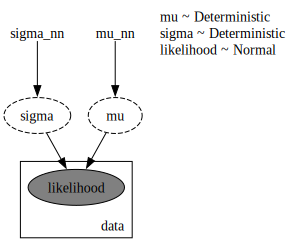

In [10]:
def model(x, y=None):
    mu_nn = flax_module("mu_nn", MLP(layers=[4, 4, 1]), input_shape=(1,))
    log_sigma_nn = flax_module("sigma_nn", MLP(layers=[2, 1]), input_shape=(1,))

    mu = numpyro.deterministic("mu", mu_nn(x).squeeze())
    sigma = numpyro.deterministic("sigma", jnp.exp(log_sigma_nn(x)).squeeze())

    with numpyro.plate("data", len(x)):
        numpyro.sample("likelihood", dist.Normal(loc=mu, scale=sigma), obs=y)


numpyro.render_model(
    model=model,
    model_args=(x_train_scaled, y_train_scaled),
    render_distributions=True,
    render_params=True,
)

**Remark:** The  [`flax_module`](https://num.pyro.ai/en/latest/primitives.html#flax-module) function consider the Flax model parameters as parameters to lear, but not really distributions. We can add priors to the parameters of the Flax model using the [`random_flax_module`](https://num.pyro.ai/en/latest/primitives.html#random_flax-module) instead. We could then pass the priors as a dictionary:

```python
mu_nn = flax_module(
    "mu_nn",
    MLP(layers=[4, 4, 1]),
    prior={
        "Dense_0.bias": dist.Cauchy(),
        "Dense_0.kernel": dist.Normal(),
        "Dense_1.bias": dist.Cauchy(),
        "Dense_1.kernel": dist.Normal(),
        "Dense_2.bias": dist.Cauchy(),
        "Dense_2.kernel": dist.Normal(),
    },
    input_shape=(1,),
)
```

## Model Fitting

We now fit the model. We use the [`SVI`](https://num.pyro.ai/en/latest/svi.html) class from `NumPyro` to do this.

100%|██████████| 5000/5000 [00:02<00:00, 2045.40it/s, init loss: 447.7928, avg. loss [4751-5000]: 116.2072]


Text(0.5, 1.0, 'ELBO loss')

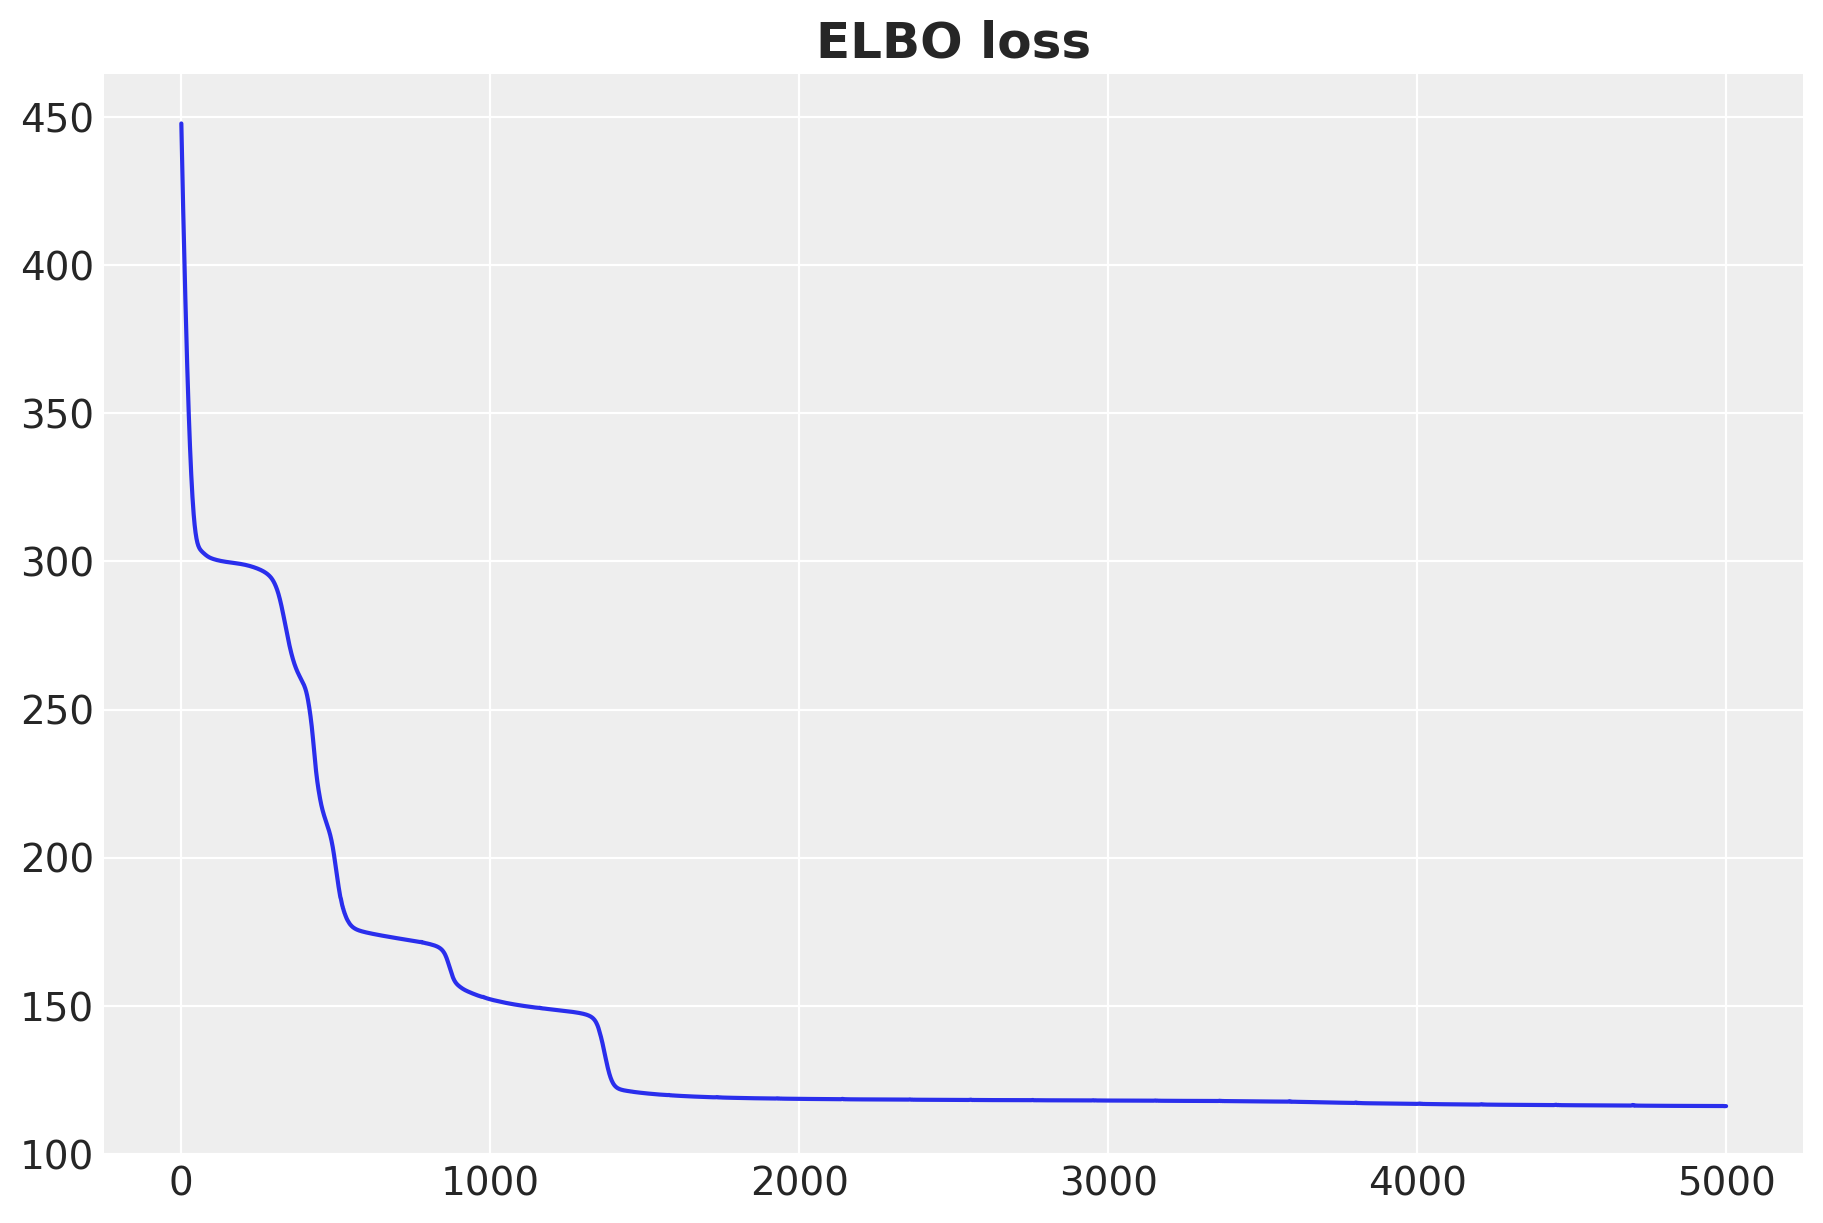

In [11]:
guide = AutoNormal(model=model)
optimizer = numpyro.optim.Adam(step_size=0.01)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
n_samples = 5_000
rng_key, rng_subkey = random.split(key=rng_key)
svi_result = svi.run(rng_subkey, n_samples, x_train_scaled, y_train_scaled)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(svi_result.losses)
ax.set_title("ELBO loss", fontsize=18, fontweight="bold")

## Posterior Predictive Checks

We now generate posterior predictive samples from the model for the training and test data.

First we generate posterior samples from the model in the scaled space.

In [12]:
params = svi_result.params
# get posterior predictive (deterministics and likelihood)
posterior_predictive = Predictive(
    model=model, guide=guide, params=params, num_samples=4 * 4_000
)
rng_key, rng_subkey = random.split(key=rng_key)
posterior_predictive_samples = posterior_predictive(rng_subkey, x_train_scaled)

We store the posterior samples in a [`az.InferenceData`](https://python.arviz.org/en/stable/api/generated/arviz.InferenceData.html) object.

In [13]:
idata_svi = az.from_dict(
    posterior_predictive={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in posterior_predictive_samples.items()
    },
    coords={"obs": obs_train},
    dims={"mu": ["obs"], "sigma": ["obs"], "likelihood": ["obs"]},
)

We now scale the posterior samples back to the original space.

In [14]:
posterior_predictive_original_scale = {
    var_name: xr.apply_ufunc(
        y_scaler.inverse_transform,
        idata_svi["posterior_predictive"][var_name].expand_dims(dim={"_": 1}, axis=-1),
        input_core_dims=[["obs", "_"]],
        output_core_dims=[["obs", "_"]],
        vectorize=True,
    ).squeeze(dim="_")
    for var_name in ["mu", "sigma", "likelihood"]
}

Let's see the posterior predictive checks for the training data:

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

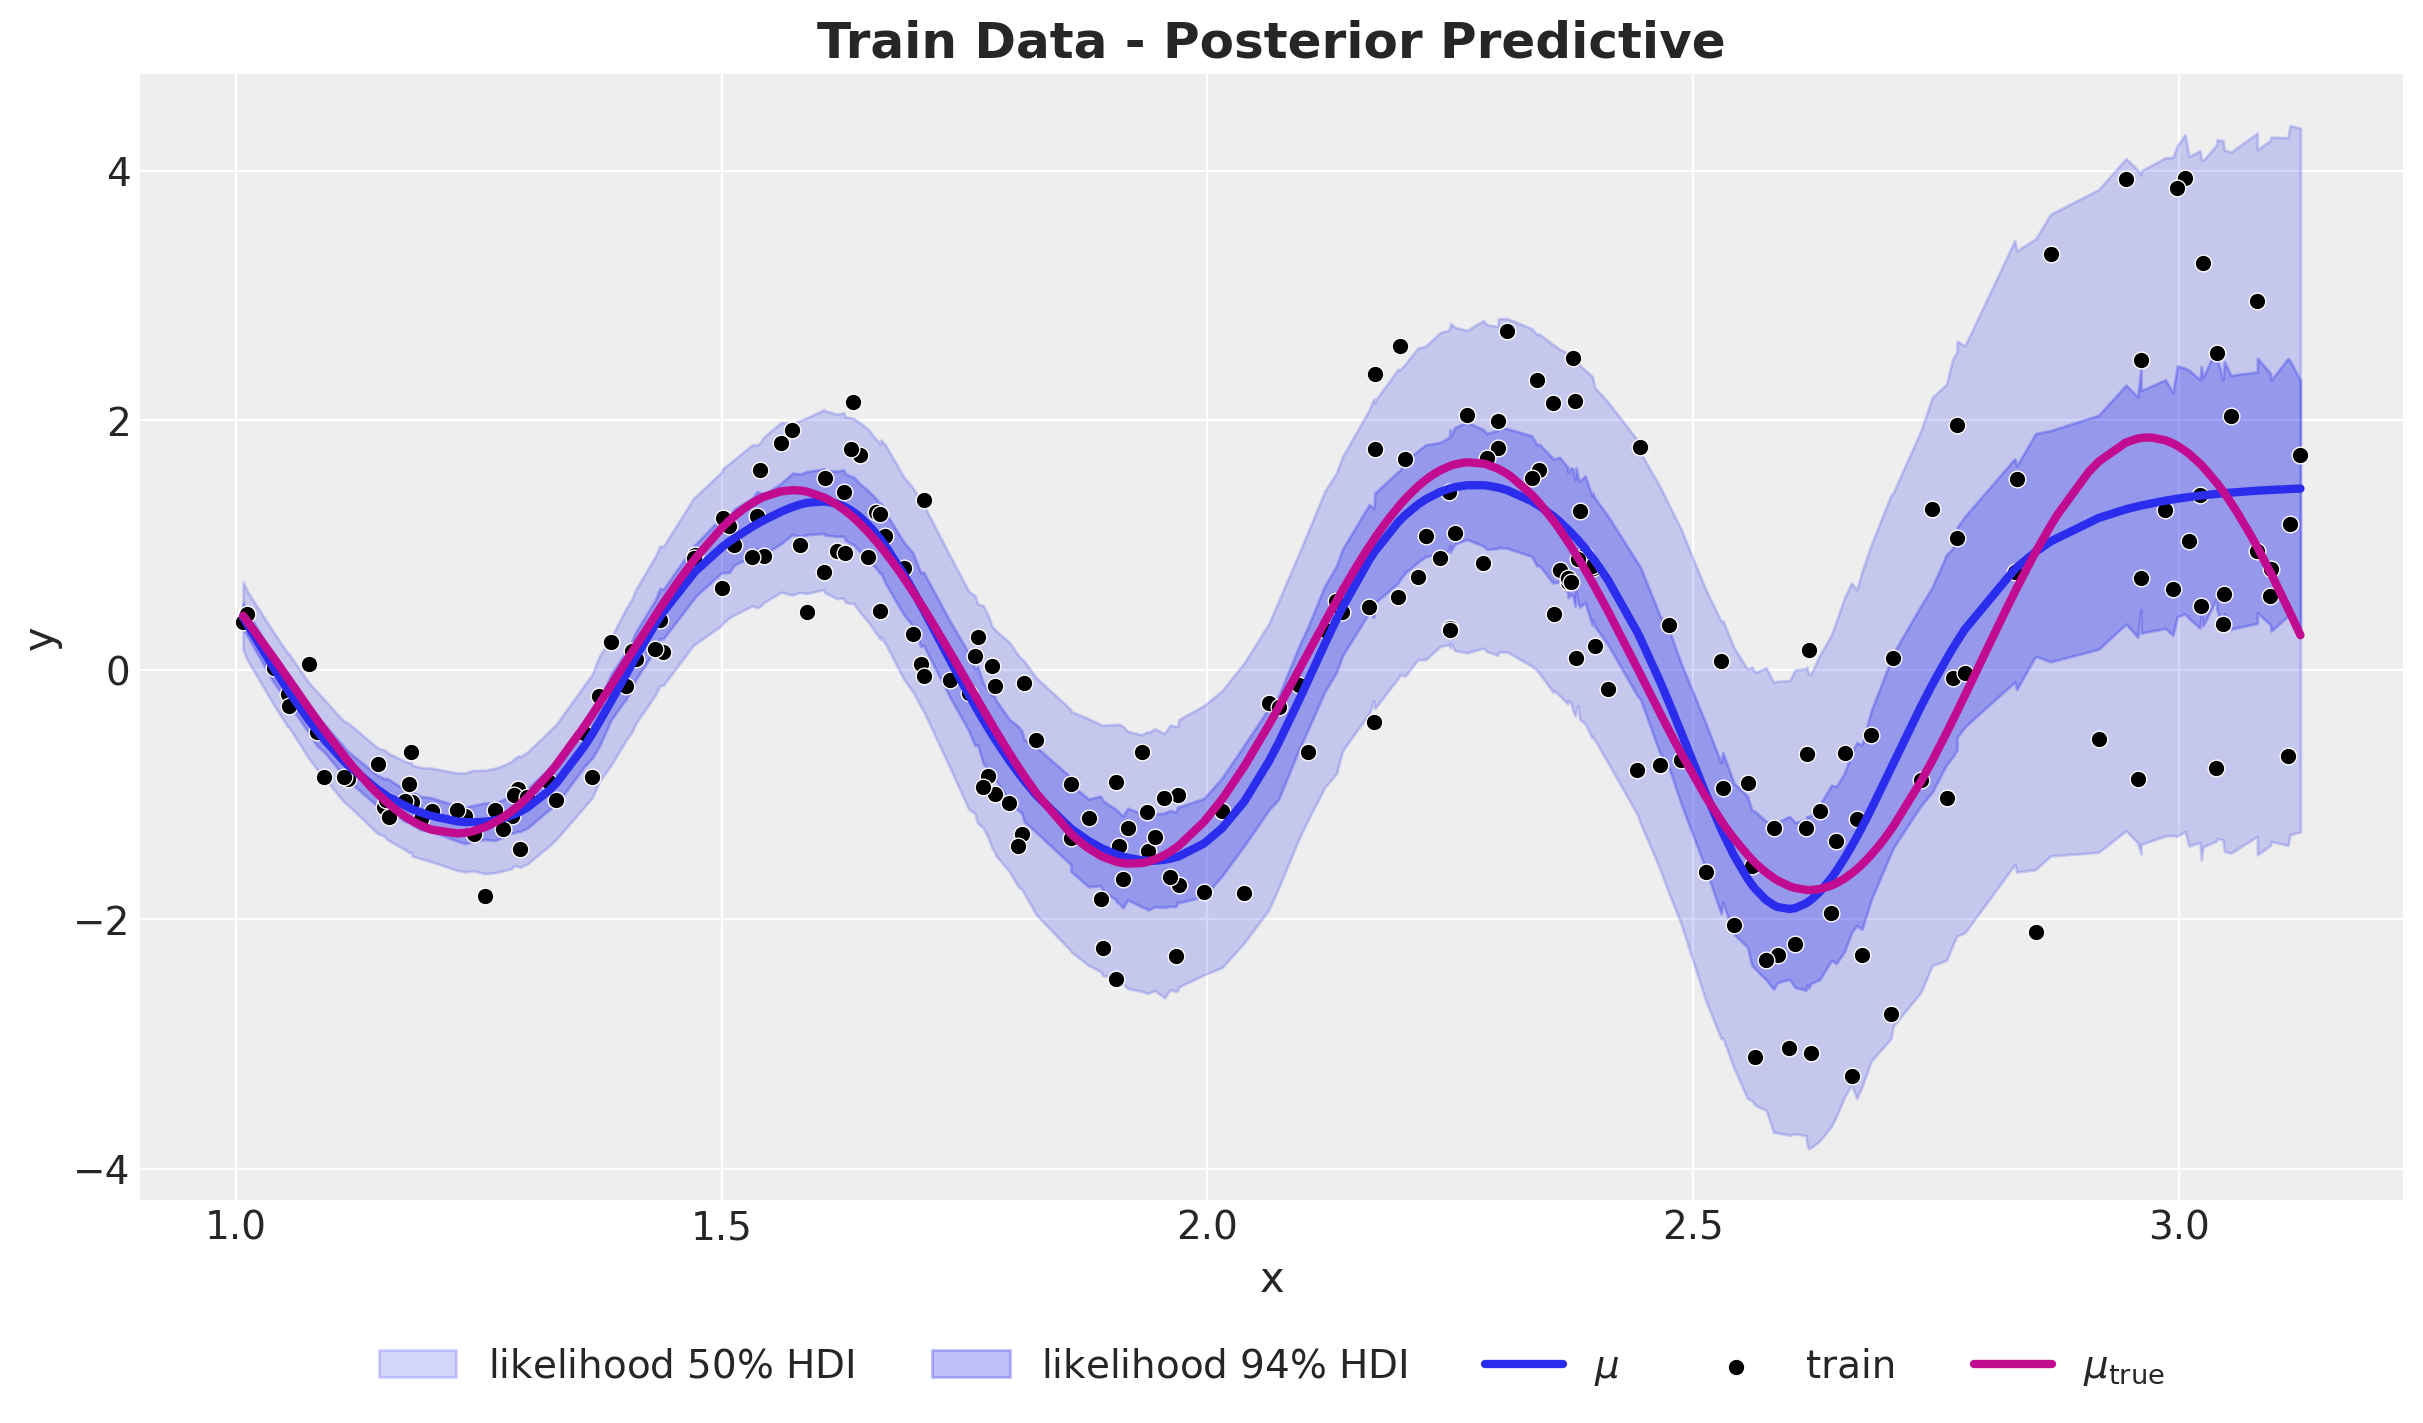

In [15]:
fig, ax = plt.subplots()
az.plot_hdi(
    x=x_train,
    y=posterior_predictive_original_scale["likelihood"],
    hdi_prob=0.94,
    color="C0",
    smooth=False,
    fill_kwargs={"label": r"likelihood $50\%$ HDI", "alpha": 0.2},
    ax=ax,
)
az.plot_hdi(
    x=x_train,
    y=posterior_predictive_original_scale["likelihood"],
    hdi_prob=0.50,
    color="C0",
    fill_kwargs={"label": r"likelihood $94\%$ HDI", "alpha": 0.3},
    smooth=False,
    ax=ax,
)

sns.lineplot(
    x=x_train,
    y=posterior_predictive_original_scale["mu"].mean(dim=["chain", "draw"]),
    color="C0",
    linewidth=3,
    label=r"$\mu$",
    ax=ax,
)

sns.scatterplot(x=x_train, y=y_train, color="black", label="train", ax=ax)
sns.lineplot(
    x=x, y=mu_true, color="C3", label=r"$\mu_{\text{true}}$", linewidth=3, ax=ax
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=5)
ax.set_title(label="Train Data - Posterior Predictive", fontsize=18, fontweight="bold")
ax.set(xlabel="x", ylabel="y")

The model seems to capture the mean and standard deviation of the data well. Still, not great at the right boundary.

We can run the same procedure for the test data:

In [16]:
predictive = Predictive(model=model, guide=guide, params=params, num_samples=4 * 4_000)
rng_key, rng_subkey = random.split(key=rng_key)
test_posterior_predictive_samples = predictive(rng_subkey, x_test_scaled)

test_idata_svi = az.from_dict(
    posterior_predictive={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in test_posterior_predictive_samples.items()
    },
    coords={"obs": obs_test},
    dims={"mu": ["obs"], "sigma": ["obs"], "likelihood": ["obs"]},
)

test_posterior_predictive_original_scale = {
    var_name: xr.apply_ufunc(
        y_scaler.inverse_transform,
        test_idata_svi["posterior_predictive"][var_name].expand_dims(
            dim={"_": 1}, axis=-1
        ),
        input_core_dims=[["obs", "_"]],
        output_core_dims=[["obs", "_"]],
        vectorize=True,
    ).squeeze(dim="_")
    for var_name in ["mu", "sigma", "likelihood"]
}

We generate the posterior predictive checks for the test data:

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

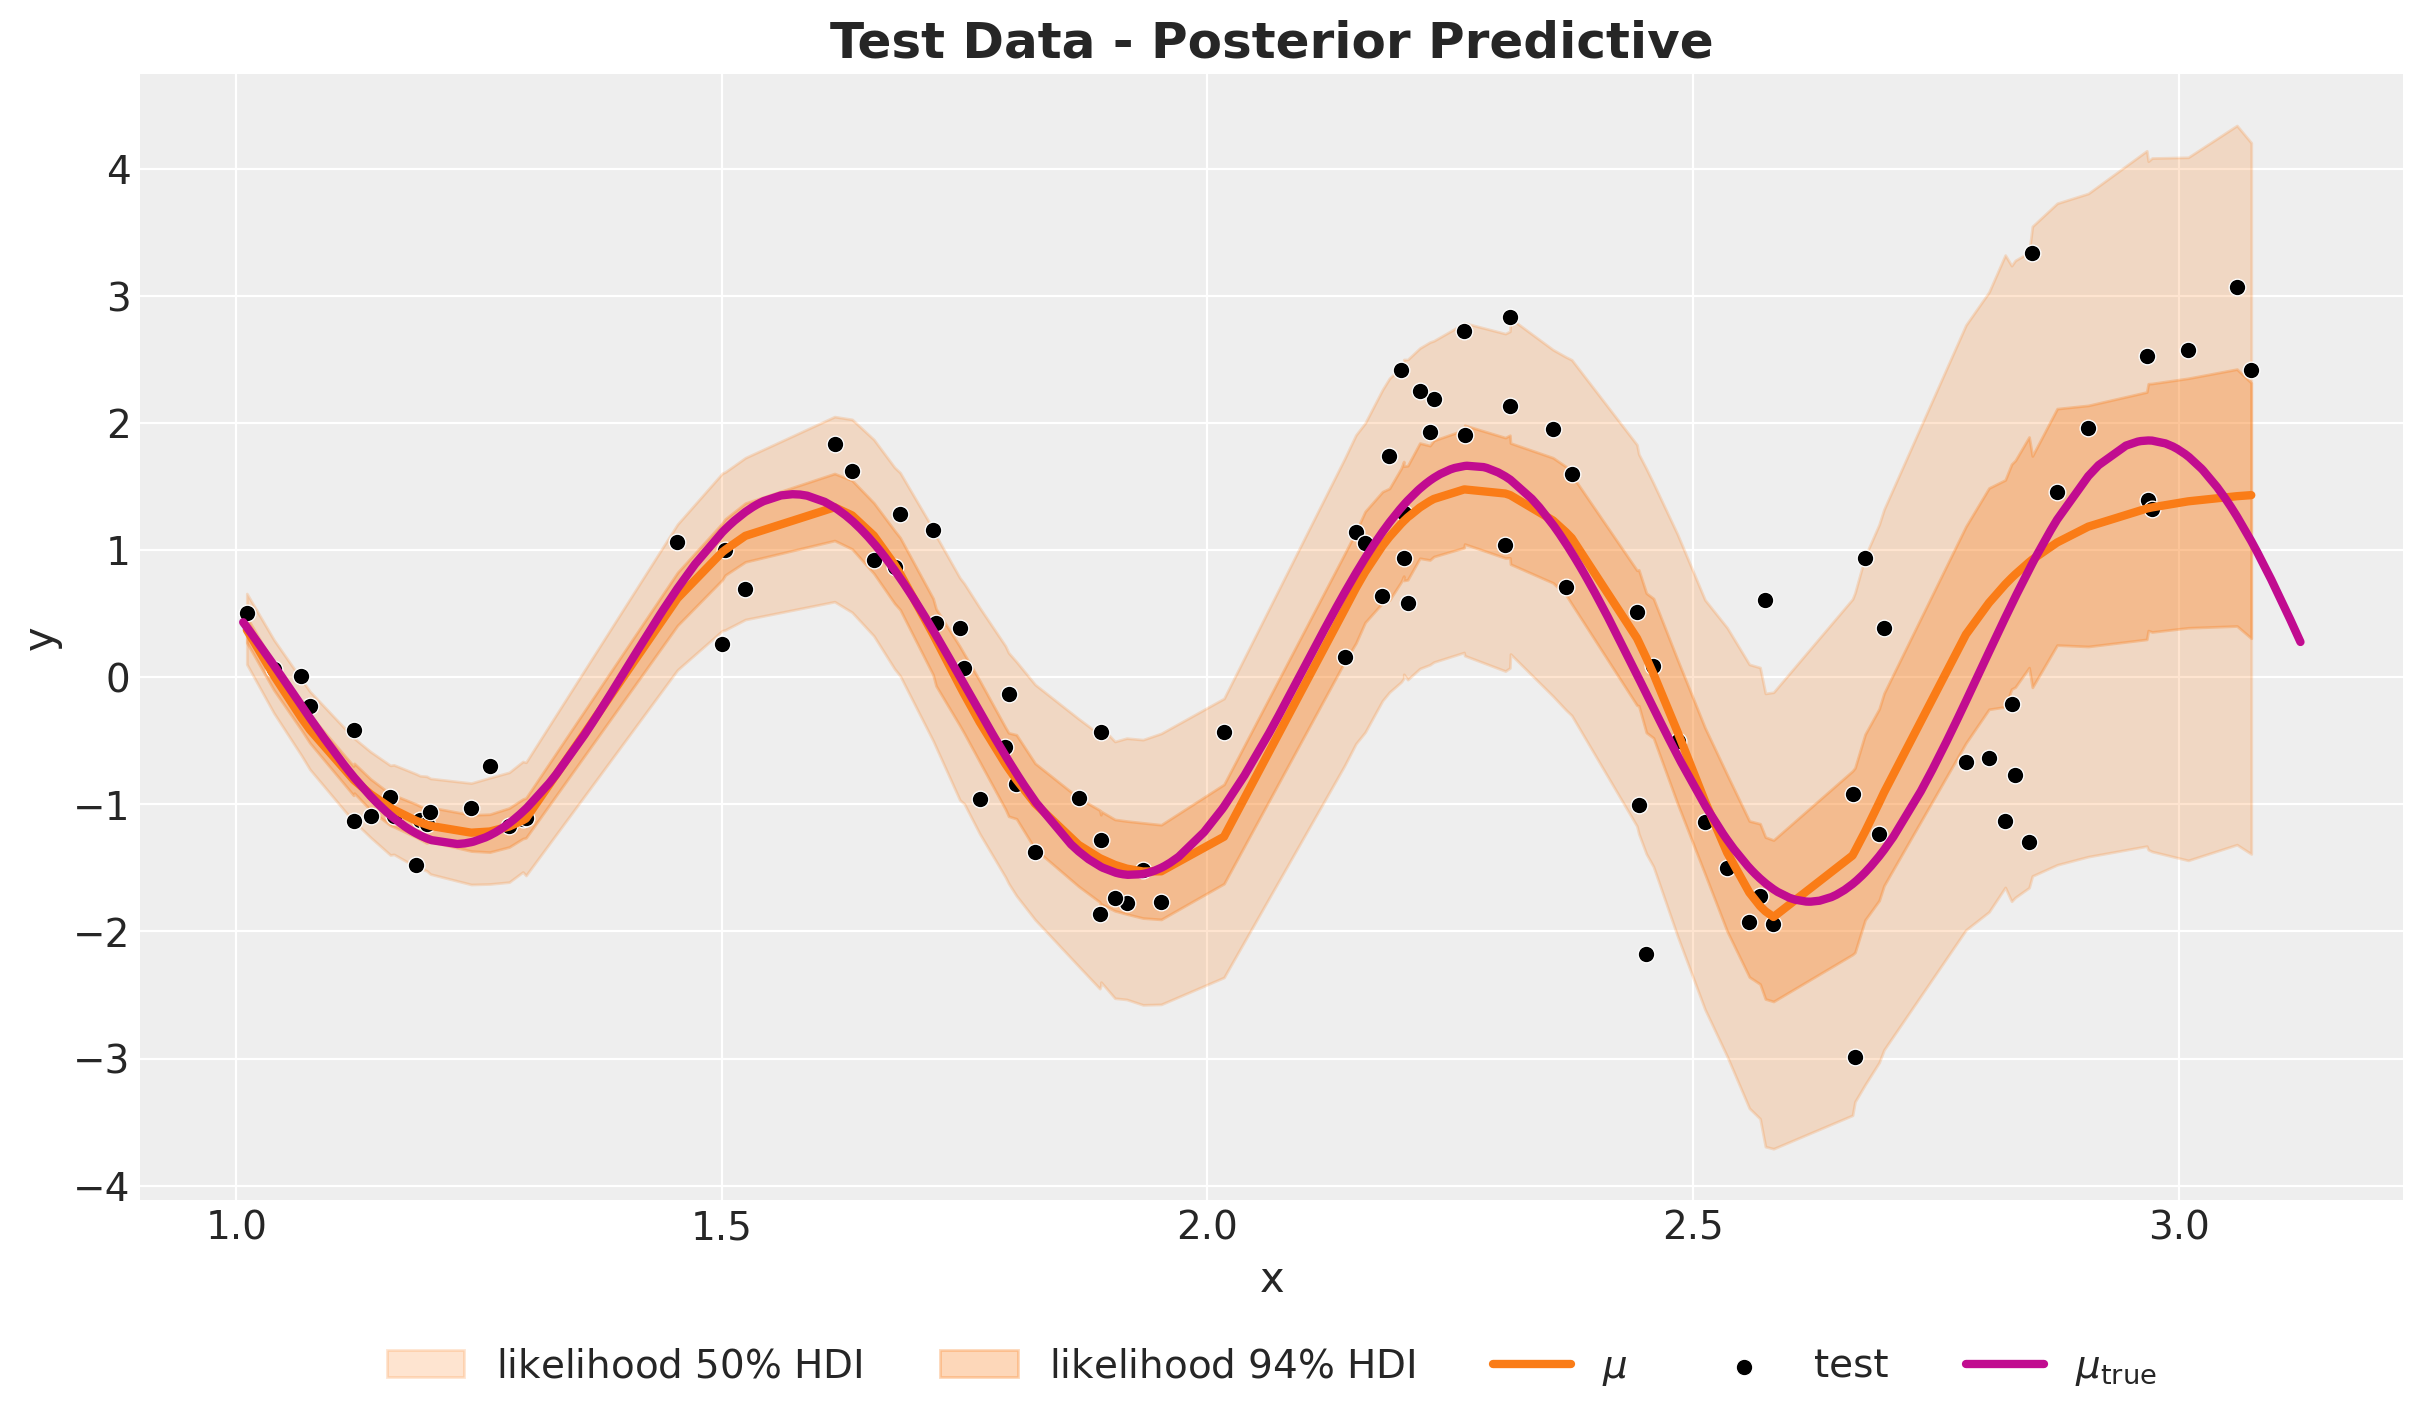

In [17]:
fig, ax = plt.subplots()
az.plot_hdi(
    x=x_test,
    y=test_posterior_predictive_original_scale["likelihood"],
    hdi_prob=0.94,
    color="C1",
    smooth=False,
    fill_kwargs={"label": r"likelihood $50\%$ HDI", "alpha": 0.2},
    ax=ax,
)
az.plot_hdi(
    x=x_test,
    y=test_posterior_predictive_original_scale["likelihood"],
    hdi_prob=0.50,
    color="C1",
    fill_kwargs={"label": r"likelihood $94\%$ HDI", "alpha": 0.3},
    smooth=False,
    ax=ax,
)

sns.lineplot(
    x=x_test,
    y=test_posterior_predictive_original_scale["mu"].mean(dim=["chain", "draw"]),
    color="C1",
    linewidth=3,
    label=r"$\mu$",
    ax=ax,
)

sns.scatterplot(
    x=x_test,
    y=y_test,
    color="black",
    label="test",
    ax=ax,
)
sns.lineplot(
    x=x, y=mu_true, color="C3", label=r"$\mu_{\text{true}}$", linewidth=3, ax=ax
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=5)
ax.set_title(label="Test Data - Posterior Predictive", fontsize=18, fontweight="bold")
ax.set(xlabel="x", ylabel="y")

Overall, the results seem very reasonable. The right boundary is still not great. In general we do not expect these models to capture patterns outside the range of the training data.

Even though the data and the model are very simple, this just serves as a concrete example for more complex scenarios were complex feature interactions trough neural networks can be beneficial in the context of bayesian modelling.